# k-means-u and k-means-u* - basic examples

This is a simple implementation of k-means-u and k-means-u* as proposed in
https://arxiv.org/abs/1706.09059


In [1]:
# these two lines ensure reload if an external module has changed
%load_ext autoreload
%autoreload 2
from kmeansu import kmeansU

In [2]:
#%matplotlib notebook
%matplotlib inline
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import copy
import warnings
import math
import random
# dataset is a class to generate artificial data sets, e.g. grid distributions
from bfdataset import dataset
# bfutil contains helper functions which are not needed in this file
from bfutil import plot3, errorOf, eqlim, noticks, finish, whoami, makeplot
# kmeansu.py contains an enriched implementation of k-means-u which collects additional
# imformation during training for figure generation and statistics.
# We do not import it here since we use the bare-bones implementation below
from kmeansu import getMap
warnings.filterwarnings('ignore')

## random vector from surface of d-dimensional unit hypersphere
see http://mathworld.wolfram.com/HyperspherePointPicking.html

In [3]:
def randUnitVec(d):
    inv_d = 1.0 / d
    gauss = np.random.normal(size=d)
    length = np.linalg.norm(gauss)
    if length == 0.0:
        x = gauss
    else:
        r = np.random.rand() ** inv_d
        x = np.multiply(gauss, r / length)
    length = np.linalg.norm(x)
    x/=length
    return(x)


## k-means-u and k-means-u*
* expects an initial clustering from k-means++ (also other starting configs are possible)
* uses the k-means implementation of scikit-learn (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [4]:
from collections import Counter
# X: data set
# kmeans: container object for
# - cluster_centers_
# - k (implicitly as len(cluster_centers))
# - inertia
# maxRetry=0: k-means-u,  maxRetry >0: k-means-u*
# ofac: constant factor to scale the length of the offset vector
def kmeansU_pure(X,kmeans, maxRetry=0,ofac=0.01):
    best = kmeans.inertia_ # lowest SSE so far
    Cbest = copy.deepcopy(kmeans.cluster_centers_)
    k = len(kmeans.cluster_centers_)
    retry = 0
    while True: # no "repeat ... until" in python, emulated as while True + break
        while True:
            cnt=Counter()
            C = kmeans.cluster_centers_ # current codebook, e.g. from random or from kmeans

            # compute error and utility for all centers
            error = np.zeros(k)
            utility = np.zeros(k)
            for i,x in enumerate(X):  # loop over all data points     
                delta = C-x           # substract current data point from centers                
                dis = np.linalg.norm(delta,axis=1) # compute L2 norm
                # find (indices of) the two closest centers (bmu=best matching unit) for the current data point
                bmu1i, bmu2i = sorted(np.argpartition(dis,2)[:2],key=lambda x: dis[x])
                cnt[bmu1i]+=1         # count for how many data points each center is bmu
                e1=dis[bmu1i]**2      # squared distance to bmu1
                e2=dis[bmu2i]**2      # squared distance to bmu2
                error[bmu1i]+=e1      # accumulate error
                utility[bmu1i]+=e2-e1 # accumulate utility
            i_maxerr = np.argmax(error) # determine index of center with max err ($\mu$)
            i_minutil = np.argmin(utility) # determine index of center min utility ($\lambda$)
            # handle special case that mu and lambda are identical
            # (seems to occur only if a completely symmetric configuration is reached were all centers
            # have the same shape of associated data: handling is to break the inner loop)
            if i_maxerr == i_minutil:
                break
            # JUMP
            md = math.sqrt(error[i_maxerr]/cnt[i_maxerr]) # standard dev around max err unit
            offset=randUnitVec(X.shape[1])*md*ofac # offset vector
            C[i_minutil]=C[i_maxerr]+offset # re-position $\lambda$
            C[i_maxerr]-=offset             # re-position $\mu$
            # REGULAR K-MEANS
            kmeans = KMeans(n_clusters=k, init = C)
            kmeans.fit(X)
            if kmeans.inertia_ < best:
                # improvement!   ==> continue ....
                best = kmeans.inertia_
                Cbest = copy.deepcopy(kmeans.cluster_centers_)
                if retry>0:
                    print("succesful retry:",retry,best)
                retry=0 # reset retry counter
            else:
                break # no improvement ==> terminate inner loop
        retry+=1
        # rewind to best solution found so far
        kmeans.cluster_centers_ = copy.deepcopy(Cbest)
        if retry > maxRetry:
            break # finish
    kmeans.cluster_centers_ = copy.deepcopy(Cbest)
    kmeans.inertia_=best
    return kmeans

# minimal k-means-u*  example 
1. create data set (see separate notebook with examples of the "dataset" class)
1. define k
1. run k-means++
1. run k-means-u (or k-means-u*) to improve the result of k-means++
1. plot the data set and the centers found


Lloyd iterations:
k-means++:    7  considering that 10 runs are done: 70
k-means-u:    3
k-means-u*:   4
Total:        14


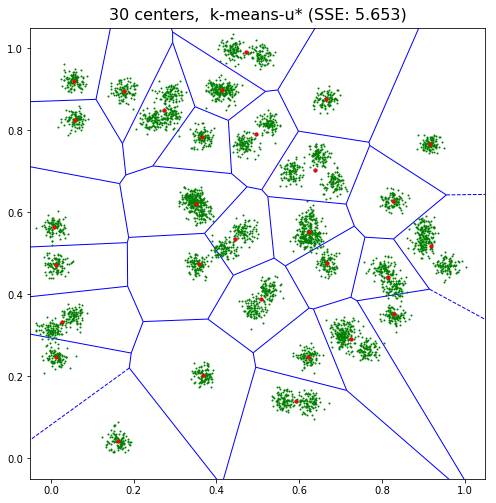

In [5]:
def fig_kmus():

    #D = dataset.grid(so=6,si=6,ratio=2,grid1=1,grid2=0,sig=0.0002)
    D = dataset.gaussmix(n=5000,g=50, sig=0.0002)
    X=D.getData()
    k= 30
    kmeans1 = KMeans(n_clusters=k,n_init=10) # define KMeans object
    kmeans1.fit(X)                 # run k-means++
    print("Lloyd iterations:")
    print("k-means++:   ",kmeans1.n_iter_, " considering that 10 runs are done:",kmeans1.n_iter_*10)
    kmeans = kmeansU(X,kmeans1,maxRetry=1,loud=0)   # result from k-means-u
    err = errorOf(kmeans.cluster_centers_,X) #compute SSE
    print("k-means-u:   ",kmeans.n_iter_u0)
    print("k-means-u*:  ",kmeans.n_iter_un-kmeans.n_iter_u0)
    print("Total:       ",kmeans.n_iter_un+kmeans1.n_iter_)
   
    fig,axs = makeplot(1,1,figsize=(7,7.0))  
    plot3(ax=axs,X=X,C=kmeans.cluster_centers_,
          cap=str(k)+" centers,  k-means-u*"+" (SSE: %.3f)"%err,
         voro=1, ticks=1)
    finish(fig,whoami())
    eqlim(axs,unitpad=0.05)
    return kmeans

km = fig_kmus()

# Figure: good and poor centers for gaussian mixture distribution
Here we show results for a data set drawn from a Gaussian mixture distribution:
* a result of k-means with random seeding and 
* a result from k-means-u*

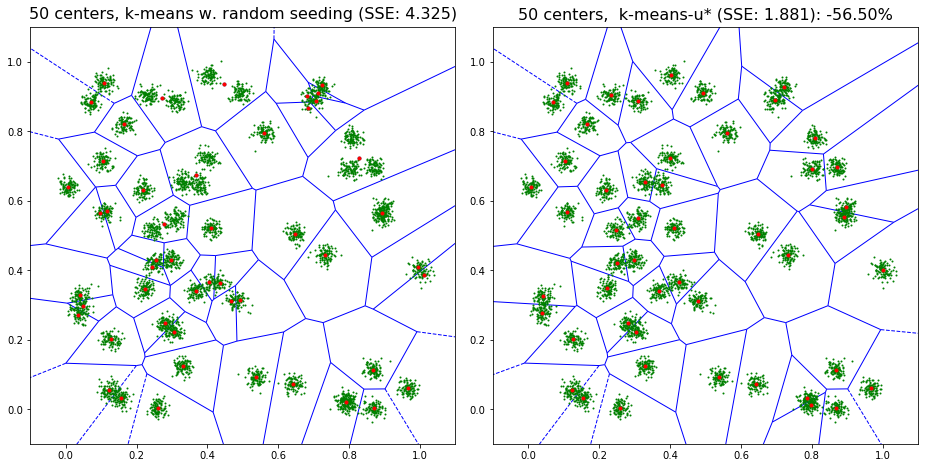

In [6]:
def fig_gaussians():

    #D = dataset.grid(so=6,si=6,ratio=2,grid1=1,grid2=0,sig=0.0002)
    D = dataset.gaussmix(n=5000,g=50, sig=0.0002)
    D.k = 50
    X=D.getData()

    D.randomInit()# initialize random codebook 
    fig,axs = makeplot(1,2,figsize=(13,6.5))  
    kmeans = KMeans(n_clusters=D.k, init=D.ibook) # run k-means
    #kmeans = KMeans(n_clusters=D.k) # run k-means++
    kmeans.fit(X)
    err1 = errorOf(kmeans.cluster_centers_,X)
    plot3(ax=axs[0],X=X,C=kmeans.cluster_centers_,
          cap=str(D.k)+" centers, k-means w. random seeding"+" (SSE: %.3f)"%err1, ticks=1, voro=1)

    kmeans = KMeans(n_clusters=D.k) # run k-means++
    kmeans.fit(X)
    kmeans = kmeansU(X,kmeans,maxRetry=2)   # run k-means-u*
    err2 = errorOf(kmeans.cluster_centers_,X)
    s=": -{:.2%}".format(1.0-err2/err1)
    plot3(ax=axs[1],X=X,C=kmeans.cluster_centers_,
          cap=str(D.k)+" centers,  k-means-u*"+" (SSE: %.3f)"%err2+s,
         voro=1, ticks=1)
    finish(fig,whoami())
    eqlim(axs, unitpad=0.1)


fig_gaussians()

## k-means-u for problem $A$-4
Data set $A$ (see https://arxiv.org/abs/1706.09059) consists of 36 clusters arranged in a 6x6 grid. Each cluster consists itself of 36 data points arranged in a (smaller) 6x6 grid. The problem $A$-4 is the task of distributing 4 times as many centers as there are clusters over data set $A$, i.e. $k=4*36=144$

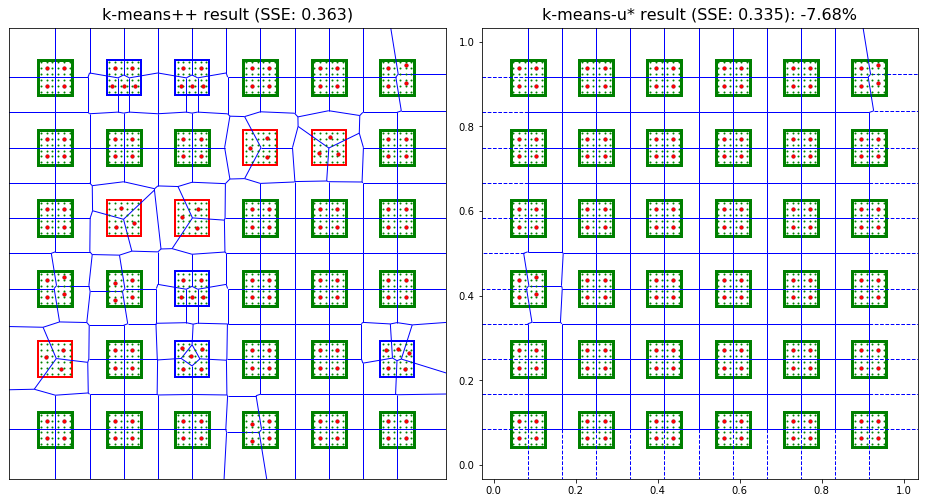

In [7]:
def fig_kmua4():
    acc=3
    fig,axs = makeplot(1,2,figsize=(13,7.0))  
    D = dataset.grid(so=6,si=6,ratio=4,grid1=1,grid2=1, relsize=0.5)

    X=D.getData()
    
    D.kmeansplusplusInit()# initialize kmpp codebook 

    n_init=10
    kmeans = KMeans(n_clusters=D.k,n_init=n_init) # run k-means++
    kmeans.fit(X)
    err1=errorOf(kmeans.cluster_centers_,X)
    if D.ratio > 0:
        cmap=getMap(D.g,D.centers,kmeans.cluster_centers_,D.ratio)
    else:
        cmap=None
    cap = "k-means++ result"+" (ratio: 4, SSE: {val:.{acc}f})".format(val=err1,acc=acc)
    cap = "k-means++ result"+" (SSE: {val:.{acc}f})".format(val=err1,acc=acc)
    plot3(ax=axs[0],X=X,C=kmeans.cluster_centers_, cmap=cmap, centers=D.centers,boxlen=D.scale,
          cap=cap,voro=1)

    maxRetry=2
    if maxRetry > 0:
        star = "*" # k-means-u*
    else:
        star = ""  # k-means-u
    kmeans = kmeansU(X,kmeans, maxRetry=maxRetry)   # result from k-means-u
    err2=errorOf(kmeans.cluster_centers_,X)
    s=": -{:.2%}".format(1.0-err2/err1)
    cmap=None if not D.grid2 else getMap(D.g,D.centers,kmeans.cluster_centers_,D.ratio)
    plot3(ax=axs[1],X=X,C=kmeans.cluster_centers_, cmap=cmap, centers=D.centers,boxlen=D.scale,
          cap="k-means-u"+star+" result"+" (SSE: {val:.{acc}f})".format(val=err2,acc=acc)+s, voro=1, ticks=1)

    eqlim(axs)

    finish(fig,whoami()+"GMM",write=0)
    return D,kmeans.cluster_centers_


dd,cb=fig_kmua4()

## k-means-u* for random points from unit square

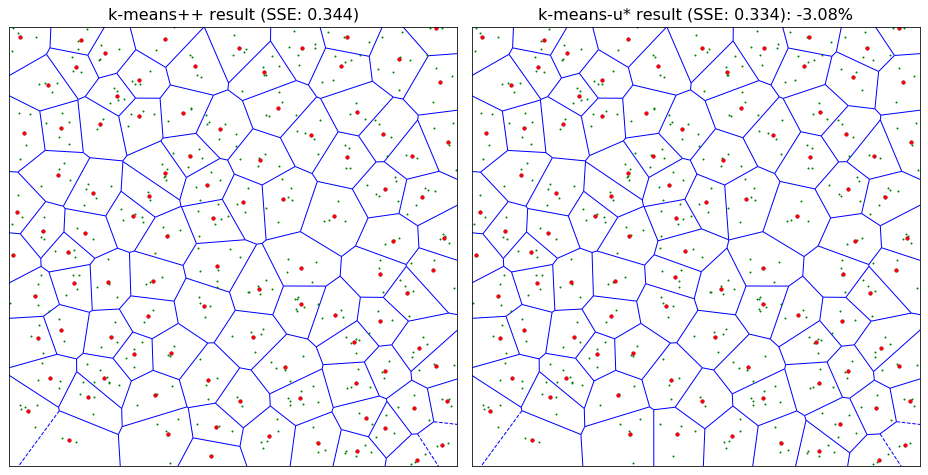

In [8]:
def fig_rand():
    X = np.random.random((400,2))
    fig,axs = makeplot(1,2,figsize=(13,6.6))  

    kmeans = KMeans(n_clusters=100) # run k-means++
    kmeans.fit(X)
    err1=errorOf(kmeans.cluster_centers_,X)
    
    plot3(ax=axs[0],X=X,C=kmeans.cluster_centers_, 
          cap="k-means++ result"+" (SSE: %.3f)"%errorOf(kmeans.cluster_centers_,X),voro=1)
    
    kmeans = kmeansU(X,kmeans,maxRetry=2)   # result from k-means-u*
    err2=errorOf(kmeans.cluster_centers_,X)
    s=": -{:.2%}".format(1.0-err2/err1)
    plot3(ax=axs[1],X=X,C=kmeans.cluster_centers_,
          cap="k-means-u* result"+" (SSE: %.3f)"%errorOf(kmeans.cluster_centers_,X)+s,voro=1)
    eqlim(axs, unitpad=0.0)
    finish(fig,whoami())


fig_rand()